<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#1-Introduction" data-toc-modified-id="1-Introduction-1">1 Introduction</a></span></li><li><span><a href="#2-Problem-statement" data-toc-modified-id="2-Problem-statement-2">2 Problem statement</a></span><ul class="toc-item"><li><span><a href="#2.1-General-problem" data-toc-modified-id="2.1-General-problem-2.1">2.1 General problem</a></span></li><li><span><a href="#2.2-Different-tasks-for-agents" data-toc-modified-id="2.2-Different-tasks-for-agents-2.2">2.2 Different tasks for agents</a></span><ul class="toc-item"><li><span><a href="#2.2.1-State-estimation" data-toc-modified-id="2.2.1-State-estimation-2.2.1">2.2.1 State estimation</a></span></li><li><span><a href="#2.2.2-Reinforcement-learning" data-toc-modified-id="2.2.2-Reinforcement-learning-2.2.2">2.2.2 Reinforcement learning</a></span></li><li><span><a href="#2.2.3-Predictive-learning" data-toc-modified-id="2.2.3-Predictive-learning-2.2.3">2.2.3 Predictive learning</a></span></li><li><span><a href="#(Extra)-2.2.4-Philosophy-of-science" data-toc-modified-id="(Extra)-2.2.4-Philosophy-of-science-2.2.4">(Extra) 2.2.4 Philosophy of science</a></span></li></ul></li><li><span><a href="#2.3-Dimensions-of-the-problem" data-toc-modified-id="2.3-Dimensions-of-the-problem-2.3">2.3 Dimensions of the problem</a></span><ul class="toc-item"><li><span><a href="#2.3.1-Observability" data-toc-modified-id="2.3.1-Observability-2.3.1">2.3.1 Observability</a></span></li><li><span><a href="#2.3.2-Observation-noise-level" data-toc-modified-id="2.3.2-Observation-noise-level-2.3.2">2.3.2 Observation noise level</a></span></li><li><span><a href="#2.3.3-Process-stochasticity" data-toc-modified-id="2.3.3-Process-stochasticity-2.3.3">2.3.3 Process stochasticity</a></span></li><li><span><a href="#2.3.4-Process-complexity" data-toc-modified-id="2.3.4-Process-complexity-2.3.4">2.3.4 Process complexity</a></span></li><li><span><a href="#2.3.5-Agent's-structure" data-toc-modified-id="2.3.5-Agent's-structure-2.3.5">2.3.5 Agent's structure</a></span></li></ul></li><li><span><a href="#(Extra)-2.4-More-things-to-discuss" data-toc-modified-id="(Extra)-2.4-More-things-to-discuss-2.4">(Extra) 2.4 More things to discuss</a></span><ul class="toc-item"><li><span><a href="#2.4.1-Is-predicting-worth-it?" data-toc-modified-id="2.4.1-Is-predicting-worth-it?-2.4.1">2.4.1 Is predicting worth it?</a></span></li><li><span><a href="#2.4.2-Belief-propagation-is-more-difficult-than-simulation" data-toc-modified-id="2.4.2-Belief-propagation-is-more-difficult-than-simulation-2.4.2">2.4.2 Belief propagation is more difficult than simulation</a></span></li></ul></li></ul></li><li><span><a href="#3-Learning-to-represent-and-track-world-state" data-toc-modified-id="3-Learning-to-represent-and-track-world-state-3">3 Learning to represent and track world state</a></span><ul class="toc-item"><li><span><a href="#3.1-Simulated-environment" data-toc-modified-id="3.1-Simulated-environment-3.1">3.1 Simulated environment</a></span></li><li><span><a href="#3.2-Baseline-state-estimator----Particle-filter-(Sequential-Monte-Carlo)" data-toc-modified-id="3.2-Baseline-state-estimator----Particle-filter-(Sequential-Monte-Carlo)-3.2">3.2 Baseline state estimator -- Particle filter (Sequential Monte Carlo)</a></span></li><li><span><a href="#3.3-Predictive-Autoencoder" data-toc-modified-id="3.3-Predictive-Autoencoder-3.3">3.3 Predictive Autoencoder</a></span><ul class="toc-item"><li><span><a href="#3.3.1-Network-architecture" data-toc-modified-id="3.3.1-Network-architecture-3.3.1">3.3.1 Network architecture</a></span></li><li><span><a href="#3.3.2-Training-scheme" data-toc-modified-id="3.3.2-Training-scheme-3.3.2">3.3.2 Training scheme</a></span></li><li><span><a href="#3.3.3-Results-of-training" data-toc-modified-id="3.3.3-Results-of-training-3.3.3">3.3.3 Results of training</a></span></li><li><span><a href="#3.3.4-Discussion" data-toc-modified-id="3.3.4-Discussion-3.3.4">3.3.4 Discussion</a></span><ul class="toc-item"><li><span><a href="#Reconstruction" data-toc-modified-id="Reconstruction-3.3.4.1">Reconstruction</a></span></li><li><span><a href="#Computations-involved" data-toc-modified-id="Computations-involved-3.3.4.2">Computations involved</a></span></li></ul></li></ul></li><li><span><a href="#3.4-Ongoing-experiments" data-toc-modified-id="3.4-Ongoing-experiments-3.4">3.4 Ongoing experiments</a></span><ul class="toc-item"><li><span><a href="#3.4.1-Sampling-from-belief-state" data-toc-modified-id="3.4.1-Sampling-from-belief-state-3.4.1">3.4.1 Sampling from belief state</a></span></li></ul></li></ul></li></ul></div>

# Learning to estimate world state

Author: *Marian Andrecki*

Contact: *marian.andrecki@gmail.com*

## 1 Introduction

Planning is undoubtedly a relevant tactic in AI and Robotics. Many tasks, such as efficient navigation or chess-playing, rely on agent's ability to simulate possible futures to determine most favourable actions. However, in order to predict reliably, agents require robust models of their environments. While the engineer often has the relevant knowledge, it may be difficult to transfer it to the agent.
1. It may be difficult to express one's understanding algorithmically -- e.g. how does one assess goodness of a Go move?
2. The mismatch between abstract mathematical models and complex unstructured reality often means the predicitions are far from useful. 

When knowledge transfer problem is challenging, one may attempt to create an agent that gains the relevant understanding from its own experience. This work focuses on construction of deployable predictive models from scratch. The goal is to understand, which aspects of environments make the learning more difficult and what subproblems need to be solved.

The idea of agents building their own models is definitely not novel: an early example is [Dyna](https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume4/kaelbling96a-html/node29.html). However, recent advances in deep learning enabled automated understanding of truly complex relationships and formation of rich representations. 

Impressive recent examples where agents learnt to successfully predict environments include:
1. [Recurrent Environment Simulators](https://arxiv.org/abs/1704.02254) and [Action-Conditional Video Prediction using Deep Networks in Atari Games](https://arxiv.org/abs/1507.08750), where a deep recurrent network learns to predict future screen frames based on past percepts and joystick data. See videoes [here](https://drive.google.com/drive/folders/0B_L2b7VHvBW2SEllTmlEX1l0RGc).
2. [Prediction Under Uncertainty with Error-Encoding Networks](https://arxiv.org/abs/1711.04994), where a network learns to sample possible futures by generating likely future percepts - in effect learning a stochastic model of the environment.

Still, even those cutting edge algorithms struggle in more challenging environments. The first one is not very good at modelling stochastic state transitions. The second one was not shown to be able to produce long-term predictions.

The primary goal of the document is present a generalised perspective on building models for high-dimensional unstructured time-series data using neural networks. The perspective of time-series prediction using recurrent networks is contrasted with more traditional state estimation methods, where dynamical models are provided to the algorithm.  

This notebook aims to delineate different challenges in learning environment models purely from percepts. In addition to theoretical considerations, pracitcal examples involving a configurable simulator of billiard balls dynamics are presented. A deep neural architectured was trained to predict to the outputs of the simulator to illustrate the theoretical concepts. The results of neural predictions are compared with near-optimal performance of sequential monte carlo methods (also know as particle filter state estimation).

The document is structured the following way:

**Section 2** describes a general problem of agent learning about its environment through lens of an information/computation flow. It then describes axes variations in the problem.

**Section 3** introduces the simulation environment used during experiments, neural architecture used for exploration and presents conceptual comparisons. Results from experiments are briefly presented.

## 2 Problem statement



### 2.1 General problem

Learning agents are spawned in various environments and are given different tasks to complete. Let us start by considering an abstraction of time-aware agent learning about its environment (Figure 1). The arrows in the graph represent computations -- however, they can also be viewed as flow of information. The vertical arrows coincide with the direction of flow of time (downwards).

Left hand side of the diagram represents computations "carried out" by the environment. State of the world evolves according to dynamics.

The right hand side refers to computations in agent's mind. The agent can try to learn the state of the world using the information flowing through the observation channel. How much of the world's state can be directly observed depends on the problem.

How information is processed in the right hand side of the graph depends on the learning algorithm chosen for the task.

<img src="images/general_problem.png" width="500" align="center">
<i>Figure 1: Graph representing computations and flow of information in the world and through agent's mind.

Consider the variables from the diagram:
* $s_t$ is state of the environment at time $t$
* $T_W$ is a computation that takes the environment from state $s_t$ to $s_{t+1}$. That is, $T_W : s_t \mapsto s_{t+1}$ 
* $o_t$ is observation at time $t$ produced by a particular sensor based on the underlying world state $s_t$
* $P_S$ is a computation that generates an observation $o_t$ from state $s_t$. That is, $P_S : s_t \mapsto o_t$
* $bs_t$ is a representation of agent's knowledge at time $t$
* $T_B$ is a computation that propagates agent's beliefs forward in time
* $P^{-1}_{B}$ is a computation that enables update of agent's belief using the observation
* $a_t$ part of the world state that is under direct control of the agent, the agent may influence the trajectory of future world states by controlling this variable (does not apply to passive agents).

The left hand side of the graph can be viewed as a [Markov process](https://en.wikipedia.org/wiki/Markov_chain) which is partially observable through the sensory channel. However, usually modelling a phenomenom as Markov process implies deciding what the format of the state is, what does transition and observation functions are. For a generalised problem we are agnostic about those. In some tasks one might decide to implement the agent with a specific format of those in mind, in others it might be the task for the agent to deicide what is the right choice of representation for the environment state and learn how transitions occur.

Representing the problem of an agent learning about its environment in as such computational graph will enable us to clearly observe different challenges that arise during learning. We will see how $T_W$ and $P_S$ vary between environments such as Atari games and colliding billiard balls and learn what it implies about difficulty of learning about those environments. Lastly, this view translates well into design of modular neural networks.

### 2.2 Different tasks for agents

Let us consider a couple of possible tasks for agents along with examples of environments usually associated with those problems. The choice of the problem dictates what kinds of computations will be implementing the agent.

#### 2.2.1 State estimation

In applications such as target tracking or robot navigation it is useful to estimate the state of the world. For example, one might be interested in tracking positions of ships scattered accross large area using noisy data from radars.

The particular variable of interest might be $(x, y)$ position of a particualar vessel and the observations consitute distance and angle towards the target (both noise corrupted).

In such problem it is usual to embed the agent with knowledge about the underlying Markov process. This informs the agent about how the state (ship's position) tends to evolve over time, and how to update one's belief about target  using data from the sensor. The state format is explicitly defined and the agent is not required to come up with a suitable representation for the problem.

Well-known examples of algorithms for this class of problems include [Kalman filter (KF)](https://en.wikipedia.org/wiki/Kalman_filter) and [Particle filter (PF)](https://en.wikipedia.org/wiki/Particle_filter) (also known as Sequential Monte Carlo). 

For these algorithms, the representation of agent's knowledge ($bs$) as well as methods for propagation beliefs into future ($T_B$) and probablistic update based on measurements ($P^{-1}_B$) are all fixed and  defined explictly by the algorithm.

In Kalman filter the knowledge is represented by multivariate Gaussian distribution over the variables of interest, eg for a target in 2D space those might be position and velocity:

<center>$s = (x, y, \dot{x}, \dot{y})^T$</center>

In a particle filter, the distribution over states is represented by a collection of copies of the state vector. Because of this PF can model non-linear processes. This generality comes at increased computational cost relative to KF.

Core weakness of this family of methods is the fact that the model of the world ($T_W$) and the sensor ($P_S$) must be at least approximately known. Any mismatch will result in lower performace of the estimators.

In this problem, most of the agent's mind is fixed (ie not changing with time).

(Pure state estimators are passive observers and do not perform actions $a$. However, in a closely related field of active sensing, agents can control their sensors (eg rotate a camera) to allow for more efficient estimation of state.)

#### 2.2.2 Reinforcement learning

In reinforcement learning the agent interacts with the environment by selecting actions ($a_t$) and tracks state of the environment ($s_t$) through observations (see game video below) ($o_t$). The agent is also provided with a scalar reward signal ($r_t$), which can be viewed as another kind of observation. The goal is to learn how to act in a given situation, so that the rewards observed are maximised.

Atari console is a recently popular testbed for a host of deep learning algorithms. The most common goal for this environment is learning to play (ie select joystick commands) in a way that maximises the game score. The problem has been popularised by seminal reinforcement learning paper [Human-level control through deep reinforcement
learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf). State of the art deep learning algorithms perform at superhuman level after roughly a day of exposure to the environment.

The environment is widely-used because it lies at the intersection of being sufficiently:
* difficult to be interesting for humans to play
* simple for early deep reinforcement learning to be successful
* accessible so that large amounts of data can be gathered for training 

<img src="images/atari.gif" width="500" align="center">
<i>Figure 2: A series of observations from Space Invaders on Atari 2600.</i>

Let us map Atari game world on abstraction developed earlier:
* $s_t$ is memory state of the console engine at time $t$. It is not human-readable, but can be understood by reading game's code.
* $T_W$ is the code that performs operations on the memory and reads the joystick. The transition function is completely deterministic given the random seed. Without it, the transitions are mildly stochastic for most games (eg which alien fires a projectile at a given time), but can be significant for some (in Asteroid the player can be teleported to a random location).
* $P_S$ there are two sensory modalities: 
    * game state is projected on the screen
        * this is fully deterministic (ie given state always leads to the same image)
        * the state is almost fully-observable -- still, there is usually some information that cannot be inferred from a single screen, eg random seed, direction of movement of enemies 
    * reward is extracted from the game state -- fully deterministic -- this signal is used as a reward in reinforcement learning 

<img src="images/dqn.png" width="800" align="center">
<i>Figure 3: A deep convolutional neural network learns a mapping from observations ($o_t$) to actions ($a_t$) that leads to highly rewarded behaviour. The layers between input and output can be viewed as agent's representation of knowledge ($bs_t$) about the aspects of game state ($s_t$) relevant for the problem.</i>

In this setting, the agent constructs knowledge representation on its own -- ie the state representation $bs_t$,  belief state transition $T_B $ and observation interpretation $P^{-1}_{B}$ are all learnt by the agent and suited to the problem (using optimisation methods for neural network training).

Under such incentives one can expect that parts of the console state that are not relevant for maxisiming game score will not be represented (which is reasonable and efficient). On the other hand, the aspects of the game that strongly affect the score (eg being hit by a bullet), will be appreciated by the agent.

Interestingly, in this setup one should not expect that the agent attempts to create a simulation of the environment in its mind. That is, the agent will not try to find internal state transition ($T_B$) such that it mimics console's state transition ($T_W$). Since every observation tells the agent almost everything there is to know about the current game state, there is little pressure to learn about state transitions.

This is generally beneficial -- there is no point in learning something that does not help to improve the performance metric. However, it could be argued that the agent is not using the data it is exposed to efficiently. Predictive learning, where the agent is tasked also with prediction of future percepts, aims to help with this problem.

#### 2.2.3 Predictive learning

In the hopes of making reinforcement learning more data efficient and also enable agents to plan (by simulating results of actions), [Yann LeCun](https://www.youtube.com/watch?v=Ount2Y4qxQo) has recently advocated that agents also learn to predict future percepts. This enables unsupervised learning (no labels required) to form richer representations of environments. The prediction problem corresponds to the modified graph below.

<img src="images/special_problem.png" width="700" align="center">
<i>Figure 4: In this task the agent produces reconstructions of observations $\hat{o}_t$. Additionally, the access to observations may be restricted for many time steps, so that the agent is incentivised to learn to propagate information forward in time.</i>


The idea is that whatever representation is sufficient for prediction of the environment (the observations to be more specific), should be suitable for estimation of 'goodness' (RL value) of a state or action selection. This representation can be formed without gathering any additional data from the environment -- the process can be completed in parallel to standard reinforcement learning. Additionally, the learnt representation along with transition function can be used to simulate the environment and plan ahead.

Again, Atari testbed is being used also for examining predictive powers of neural networks. In this setting the agent is tasked with prediction of future percepts (up to hundreds of time steps ahead). Video examples of predictions can be found in the following directory: [here](https://drive.google.com/drive/folders/0B_L2b7VHvBW2SEllTmlEX1l0RGc).

<img src="images/env_sims.png" width="700" align="center">
<i>Figure 5: Graphical representation of computations in neural architecture for Atari prediction in [Recurrent Environment Simulators](https://arxiv.org/abs/1704.02254). $x_t$ and $\hat{x}_t$ are game frame and its reconstruction at time $t$, $s$ corresponds to belief about game state, $a$ corresponds to joystick action.</i>

The only information supplied to the agent are observations and joystick actions (which can be viewed as an observation or part of state). In the process of prediction of future percepts, the agent:
1. updates its belief $bs_t$ about the state of environment $s_t$ using the observation $o_t$ (convolutional network)
2. propagates its belief forward in time to $bs_{t+1}$ (recurrent network)
3. maps the belief $bs_{t+1}$ onto observation space $\hat{o}_{t+1}$ (deconvolutional network)

The procedure is improved iteratively via gradient descent on the error in reconstruction. Once the network has converged it was capable of simulating behaviour of Atari console for hundreds of timesteps. Effectively, the agent has found a sufficiently rich state representation along with transition function that matches closely the original residing in the Atari 2600.

However, the success in Atari prediction problem did not readily translate to other domains. Video predictions continue to be very challenging.

A particular feature of Atari problem that makes it relatively easy is the fact the that games used in the aforementioned experiments where mostly deterministic. That is, $T_W$ contains little noise. This means, that the agent can do well on the task by representing the state of the game and simulating it forward. This is in contrast to having a belief over a distribution of possible states and propagating this distribution forward in time.

My current interest is in extending the method used in Atari prediction research for environments that contain significant levels of stochasticity. More on how this is being tackled in Section 3.

#### (Extra) 2.2.4 Philosophy of science

Humanity's quest for knowledge can also be viewed through the lens that we have established. Science aims to construct and retain best explanations about how the underlying world works. To achieve that, collectively we are a very flexible learner. We use various representation for the same object depending on the problem that is being solved. For example, a glass full of liquid can be modelled as:
* a collection of molecules by a physicist
* a substance with particular chemical properties by a chemist
* a graspable object by someone who is consuming a morning coffee

Our flexibility in which model should be used can go as far as in quantum physics, where physicists offer multiple interpretations on how the reality behaves at the lowest levels and do not really worry about which is "true" as long as they all make the same predictions about the future.

In language established in this document this means -- it does not matter which state representation you choose as long your predictions match the observations.

Still, in our search for answers we are driven by values. We are not abstractly trying to predict everything. We focus our attention on predictions of phenomena that are consequential to our survival and improvement of quality of life. (Just as neural network training is driven by a particular loss function.)

### 2.3 Dimensions of the problem

Now that a number of examples of environments, agents and corresponding tasks were considered let us try to abstract away some components of the problem. What effect do those have on difficulty of training for an agent?

#### 2.3.1 Observability

**Full** -- $P_S$ is an identity matrix -- the agent has full access to state at all times. Example: many abstract games, eg chess.  In such settings finding suitable transition function might be easier (since state is known at all times). Not a very interesting case in itself as it is rarely found in the real world.

**High** -- multiple states can map to the same observation, because of that state cannot be directly inferred from a single observation. Still, it is possible to end up with a narrow distribution. Multiple consecutive observations can possibly eliminate all relevant uncertainty. Examples: Atari games, robot localisation, military target tracking. Since the agent has poorer estimate of world state at all times, it is more challenging to infer the transition function.

**Low** -- even with large number of observations it is not possible to infer everything about the state of the environment. Only some parts of the state can be known with high certainty. Examples: agents embedded in large worlds, eg games like GTAV or Starcraft, simultaneous localisation and mapping, living as a human. The transition function has to be learn part by part since entire state is never known with high certainty.

#### 2.3.2 Observation noise level

The noisier the observations, the more difficult it is to infer the state that lead to generation the observation. Higher level means that the agent has to maintain a broader distribution over possible states of the environment. All real-world measurements are noise-corrupted to some extent.

#### 2.3.3 Process stochasticity

**Deterministic transition function** -- in such environments the agent that already possess a good approximation of $T_W$ can predict arbitrarily far into the future (provided computational resources are sufficient). If the agent can narrow down its beliefs about state to a single option, from that point onwards it can simply simulate the environment rather than propagating its beliefs about the environment. (This is Atari predictions case.)

**Stochastic transition function** -- any information that the agent gains about the environment is gradually lost as the state evolves in a random manner. The agent has to update its beliefs using observations.

#### 2.3.4 Process complexity

It is possible for the underlying environment to be completely deterministic, yet composed of so many parts or complicated rules that to the agent it appears stochastic (either because of lacking model or shortage of computational resources).

It is likely that die throwing as a macroscopic phenomenom is practically governed by Newtonian mechanics and is almost completely deterministic (or let us assume this to make an example). Still, for any human onlooker, completely incapable of predicting the result from initial die position and force used, the throw will feel entirely random.

Systems that are determinisitic but chaotic (small change in initial conditions leads to large difference in outcome) often have to be modelled as stochastic anyway. Still, the level of chaos that pushes the system into as-if-it-was-stochastic region depends on the predictive power of the agent. Ie unpredictability can be a feature of the mind observing the process rather than of the process itself.

#### 2.3.5 Agent's structure

For different problems different parts of the agent's mind can be made flexible. For example, in state estimation the problem representation and state transition are given and immutable. In problems where neural networks are used, the agent forms the representation based on the incentives provided by the loss function.

### (Extra) 2.4 More things to discuss

#### 2.4.1 Is predicting worth it?

It is certainly true, that for some problems it is not worth it to make diligient plans relying on predictions (model-based reinforcement learning). Sometimes it is better to "just do it" (model-free reinforcement learning). What differentiates the settings where either of these tactics is preffered to the other one? This certainly calls for a longer discussion. Let us bring some points for now.

When do humans plan vs. just act?
* Degree choice -- plan
* Selecting friends -- just act
* Marry someone -- plan
* How to play football -- just act
* How to go through complicated crossroads -- plan
* What to eat -- just act (mostly)

How does that relate to Kahneman's System1 and System2?

Where does model-free RL vs. planning succeed?
* high-dimensional, no model available -- MFRL
* chess, Go, etc. -- mix, but more like planning
* robot locomotion -- planning
* robot manipulation -- mix
* simulated learning to walk -- MFRL

In [1]:
# in progress

# What predicts which approach will work *better* for a given problem depends on the relative costs of failing in the environment and of making reliable predictions.

# **Cost of failure** -- when behaving suboptimally is costly, eg when the agent can enter a state which it can never leave (say, by self-destructing), it is important to plan ahead. If, on the other hand, failing is cheap, as in Atari setting, the agent might as well learn to avoid worse states by trial and error. By not planning the agent may have to go through a larger number of trials, but it is possible that the ultimate performance doesn't suffer.

# **Quality and cost of making predictions** -- in sitations where planning is not reliable, eg the environment is inherently chaotic, or the cost of making reliable predictions is very high, the prolonged delibaration may not bring sufficient value to the agent.

# For an Atari playing agent it is computationally costly to predict consequences of an action. One has to predict potentially dozens of timesteps ahead with branching factor on the order of 10. The alternative to planning is to act without deliberation and try to interpret actually ocurring consquences of the action to learn from experience. The cost of a failure is very low as the game can be restarted at any time. Thus, current approaches favour

# An algorithm for an intelligent robot acting in the real world should reflect the reality that some of the actions are not just *bad* (from perspective of reward maximisation). Some actions are optimisation-terminating. There is nothing to learn from an experience if the agent is destroyed.

#### 2.4.2 Belief propagation is more difficult than simulation

## 3 Learning to represent and track world state

In the previous section we saw that Deepmind successfully implemented an algorithm capable of learning state transitions of Atari 2600 games. As a result the deep neural network can be used to simulate of the environment it was trained on. Unfortunately, Atari 2600 environment is highly-observable and mostly deterministic. In other words, it is very different from our world. Thus the method cannot be readily ported to, for example, autonomous cars, which would probably benefit from the ability to predict future.

In this section, I outline some of tactics and problems associated with enabling high-dimensional percept predictions for stochastic environments. Note, that particular methods and experiment results are presented here only briefly. Expect more details on inner workings of the system in the future research publication.

### 3.1 Simulated environment

In order to have full control over the difficulty of the learning task a contraolable simulator was implemented. This allows for adjustment of the dynamics of the environment. In the simulation, billiard balls are interacting via Newtonian mechanics. The parameters of the simulation can be controlled in order to make the learning task more challenging. For example, the level of stochasticity in ball motion (random force perturbation) can be changed.

The balls are simulated in a continuous space. Depending on the setting the balls can pass through each other or walls to emerge on the other side of the area. The state of simulation is projected onto $28$ by $28$ black and white image. This image serves as an observation to the agent. 

See samples generated by the simulator below.

In [2]:
%cd ~/code/projects/nn-play/
import numpy as np
import matplotlib.pyplot as plt
import imageio
import copy
from IPython.display import HTML
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/home/ira/code/projects/nn-play


In [3]:
from balls_sim import World, DEFAULT_SIM_CONFIG
gif_counter = 0

In [4]:
conf = copy.deepcopy(DEFAULT_SIM_CONFIG)
conf['n_bodies'] = 3
conf['dynamics_noise'] = 0.01
conf['ball_action'] = 'bounce'
conf['wall_action'] = 'bounce'

w = World(**conf)
gif_counter += 1
ims = []
for i in range(150):
    w.run()
    ims.append(w.draw())

imageio.mimsave("ims/{}.gif".format(gif_counter), ims)
HTML('<img src="../ims/{}.gif" width="280">'.format(gif_counter))

### 3.2 Baseline state estimator -- Particle filter (Sequential Monte Carlo)

Before training a neural network to predict sequences of balls interacting it is useful to construct a model-based baseline. In this case a particle filter (PF) is used. It is a standard method for state estimation when models of phenomenom and sensor are known. See Section 2.2.1 for more information on state estimation.

PF operates by running $n$ simulations of the environment in parallel (prediction step). Then the simulations that are unlikely to produce a measurement similar to the one observed are decimated (update step). The copies of the simulated environment consitute samples from the belief distribution of the filter.

PF operates only on structured data (ie not images). However, the belief distribution over structured $(x, y)$ positions can be converted into images. The higher the uncertainty associated with a position of a given ball, the more blur there is in the image.

PF starts with knowledge of initial position of the balls. Then its uncertainty in estimate increases due to stochasticity in the system.

In the limit of infinite number of particles (copies of environments) used, PF holds optimal rational beliefs about the positions of the balls. In practice, PF tends to fail for high dimensional problems, but for this toy example its performance can be considered near-optimal.

See videos from a run of simulation (ground truth), PF's belief, a representative sample from the belief distribution in the table below.

In [5]:
from particle_filter import ParticleFilter  # see here for implementational details

Uninformative baseline level at 0.0455353781580925


Ground truth,Belief,Sample
,,


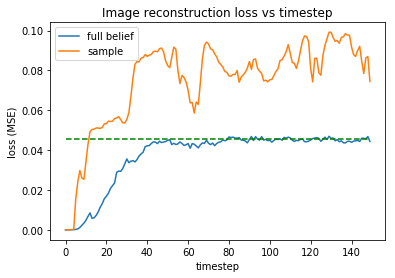

In [6]:
conf = copy.deepcopy(DEFAULT_SIM_CONFIG)
conf['radius'] = 2.0
conf['dynamics_noise'] = 0.01
conf['measurement_noise'] = 0.0003
conf['n_bodies'] = 4
conf['ball_action'] = 'bounce'
conf['wall_action'] = 'bounce'

w = World(**conf)
gif_counter = 0

pf = ParticleFilter(conf, n_particles=400)

pos = [body.pos for body in w.bodies]
vel = [body.vel for body in w.bodies]
pf.warm_start(pos, vel=vel)

ims = []

ims_percept = []
ims_belief = []
ims_sample = []

loss_mse = []
loss_sample_mse = []
loss_mae = []

for i in range(150):
    if i < 0:
        measures = [body.pos for body in w.bodies]
        pf.update(measures)
        pf.resample()
    
    w.run()
    pf.predict()
    
    percept = w.draw()
    belief = pf.draw()[:,:,0]
    sample = pf.parts[0].draw()
    
    loss_mse.append(np.mean((percept-belief)**2))
    loss_sample_mse.append(np.mean((percept-sample)**2))
    
    ims_percept.append(percept)
    ims_belief.append(belief)
    ims_sample.append(sample)


imageio.mimsave("ims/{}-percept.gif".format(gif_counter), ims_percept)
imageio.mimsave("ims/{}-belief.gif".format(gif_counter), ims_belief)
imageio.mimsave("ims/{}-sample.gif".format(gif_counter), ims_sample)

ims_ar = np.array(ims_percept)
av_pixel_intensity = np.mean(ims_ar)
baseline_level = np.mean((ims_ar-av_pixel_intensity)**2)
baseline = np.ones(len(loss_mse)) * baseline_level
print("Uninformative baseline level at {}".format(baseline_level))

plt.plot(loss_mse)
plt.plot(loss_sample_mse)
plt.plot(baseline, 'g--')

plt.title("Image reconstruction loss vs timestep")
plt.ylabel("loss (MSE)")
plt.xlabel("timestep")
plt.legend(["full belief", "sample"])

HTML("""
<table>
  <tr>
    <th>Ground truth</th>
    <th>Belief</th> 
    <th>Sample</th>
  </tr>
  <tr>
    <td><img src="../ims/{0}-percept.gif" width="140"></td>
    <td><img src="../ims/{0}-belief.gif" width="140"></td> 
    <td><img src="../ims/{0}-sample.gif" width="140"></td>
  </tr>

</table>""".format(gif_counter))

The graph above shows the error in reconstruction of the observation given PF's beliefs across timesteps. This function is of interest because it will serve as a basis for neural network training.

The dotted green line represents *uninformative baseline*, that is, the reconstruction error under belief that balls can be anywhere in the image.

The reconstruction error based on PF's full belief starts at 0 when state of the balls is perfectly known (upon PF initialisation). Then as uncertainty increases due to stochasticity in the system the error increases. However, it never goes above the *uninformative baseline* level.

A reconstruction of a sample from belief distribution, on the other hand, performs much worse on this metric.

### 3.3 Predictive Autoencoder

With the baseline established it is now possible to train a neural network that is tasked with prediction of future percepts. It should not be possible for the network to beat PF's score. This is because PF starts with perfect knowledge of transition model, observation model and ideal problem problem representation. The neural network has to find all of those through training.

Once the network is capable of making well-scoring predictions, it can be said it has implicitly learnt the underlying rules of the environment. (However, those are encoded by network's weights and are not human readable.) Such a trained network can be used to simulate the environment. A representation that allows for predictions should also be suitable for value-learning (though this is not particularly relevant in this research since the agent is a passive observer).

The network was implemented using PyTorch library.


#### 3.3.1 Network architecture

Consider the diagram below to understand how the data flows through the network to complete the training (and perform predictions).

[Autencoder](https://en.wikipedia.org/wiki/Autoencoder) is a type of neural architecture which consumes a particular input (eg image), passes it through layers with dimensionality lower than that of the input, thus  encoding the data, then the input is reconstructed from the code. By performing this seemingly not very useful reconstructive operation, the network can find suitable representations of input in an unsupervised manner. This is often used as a pre-training step for problems with small amounts of labelled data. Autoencoders are also successful as generative models and image denoisers.

In predictive autencoder, the predictions about future percepts are made in the low-dimensional (encoded) space with use of recurrent layers (usually LSTM or GRU).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Autoencoder_structure.png/350px-Autoencoder_structure.png" width="700" align="center">
<i>Figure 6: A diagram depicting an autoencoder (from Wikipedia's article).</i>


Consider the flow of information through the network.

An observation $o_t$ at time $t$ is fed into the network with probability $p_{obs}$ from the sequence of images generated by the simulator. The image is first encoded using convolutional layers and is fed into a recurrent layer (see [Gated Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit)). This layer combines existing information about the state of the environment from the last timestep with the information coming from new image, call this belief state ($bs_t$). Belief state is then propagated forward in time, but also used to reconstruct the observation $\hat{o}_t$ using deconvolutional layers.

<img src="images/special_problem.png" width="700" align="center">
<i>Figure 7: This graph was shown before. The predictive autoencoder corresponds to the right half of the diagram, ie agent's mind. The network produces reconstructions of observations $\hat{o}_t$. Note that the access to the observations must be restricted, so that the agent is incentivised to learn to propagate information forward in time.</i>

Let us connect the two diagrams. The encoding is performed by convolutional layers and corresponds to operation using  $P^{-1}_{B}$. The encoding corresponds to estimate of the state of environment $bs_t$. Recurrent layers implement predictions in the encoded space and updated with information from new observation -- reflecting $T_B$. Finally, the deconvolutional layers reconstruct an observation from belief state, which maps onto $P_B$.

#### 3.3.2 Training scheme

With the architecture ready it is now possible to train the network.

The data is a set of 1000 episodes, each consisting of 100  consecutive observations. A batch of episodes is set at the input and output of the network (autoencoder is meant to reconstruct whatever input it is presented with). The loss function used to guide the search for suitable parameters is mean squared error. Optimiser used is Adam.

There are two important complications to this setup. 

Firstly, if the training was carried out in the way specified thus far, the network would not be incentivised to propogate information forward in time. If observations are available at all times, then it suffices to reconstruct the image from whatever was presented at the input.

To prevent this, each observation can be randomly selected with probability $(1 - p_{obs})$ to be masked with 0-values, thus destroying the information contained in the percept. Regardless of that, the loss function still demands that the observation is reconstructed in an unmasked form. To achieve this the network has to pull relevant information about the environment from previous timesteps. This incentivises network to estabish well functioning recurrent layer.

Secondly, the probability of displaying an observation decrease with the progression of the training. The network is always tasked with reconstruction of 100% of the percepts. However, in the initial stages of training about 80% of the observations will fed into the architecture without masking. During the final stages, the network is presented with only a couple initial frames of the episode.

Progressively increasing difficulty of the training task allows for speed up of learning. This approach is reffered to as *gradual learning*.

#### 3.3.3 Results of training

The blocks of code below load a trained network and test its performance as a predictor of observations by comparing it side by side with particle filter.

In [7]:
from torch_nets import *
import torch
from torch.autograd import Variable

In [8]:
pae = PredictiveAutoencoder(v_size=256)

In [9]:
pae.load_state_dict(torch.load('experiments/1b_pass_det/autencoder_epoch_4.pth'))

Uninformative baseline level at 0.012007104232907295


Ground truth,Particle Filter,Predictive Autoencoder
,,


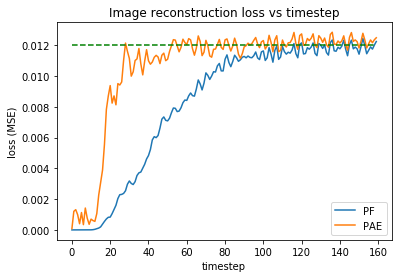

In [10]:
conf = copy.deepcopy(DEFAULT_SIM_CONFIG)
conf['radius'] = 2.0
conf['dynamics_noise'] = 0.01
conf['measurement_noise'] = 0.0003
conf['n_bodies'] = 1

w = World(**conf)
gif_counter = 2

pf = ParticleFilter(conf, n_particles=400)

pos = [body.pos for body in w.bodies]
vel = [body.vel for body in w.bodies]
pf.warm_start(pos, vel=vel)

ims = []

ims_percept = []
ims_belief = []
ims_sample = []

loss_mse = []
loss_sample_mse = []
loss_mae = []

for i in range(160):
    if i < 8:
        measures = [body.pos for body in w.bodies]
        pf.update(measures)
        pf.resample()
    
    w.run()
    pf.predict()
    
    percept = w.draw()
    belief = pf.draw()[:,:,0]
    sample = pf.parts[0].draw()
    
    loss_mse.append(np.mean((percept-belief)**2))
    loss_sample_mse.append(np.mean((percept-sample)**2))
    
    ims_percept.append(percept)
    ims_belief.append(belief)
    ims_sample.append(sample)

    
# run predictions with the network
x = np.array(ims_percept)
x = x.reshape((1, 160, 28, 28, 1))
x[:,8:, ...] = 0
x = x.transpose((1, 0, 4, 2, 3))
x = torch.FloatTensor(x)
# x = x.cuda()
x = Variable(x)
pred = pae(x)

pred = pred.data.cpu().numpy()
pred = pred.reshape((160, 28, 28))

pae_ims = []
loss_pae = []
for i in range(160):
    pae_ims.append(pred[i, ...])
    loss_pae.append(np.mean((ims_percept[i]-pred[i, ...])**2))


imageio.mimsave("ims/{}-percept.gif".format(gif_counter), ims_percept)
imageio.mimsave("ims/{}-belief.gif".format(gif_counter), ims_belief)
imageio.mimsave("ims/{}-pae.gif".format(gif_counter), pae_ims)

ims_ar = np.array(ims_percept)
av_pixel_intensity = np.mean(ims_ar)
baseline_level = np.mean((ims_ar-av_pixel_intensity)**2)
baseline = np.ones(len(loss_mse)) * baseline_level
print("Uninformative baseline level at {}".format(baseline_level))

plt.plot(loss_mse)
plt.plot(loss_pae)
plt.plot(baseline, 'g--')

plt.title("Image reconstruction loss vs timestep")
plt.ylabel("loss (MSE)")
plt.xlabel("timestep")
plt.legend(["PF", "PAE"])

HTML("""
<table>
  <tr>
    <th>Ground truth</th>
    <th>Particle Filter</th> 
    <th>Predictive Autoencoder</th>
  </tr>
  <tr>
    <td><img src="../ims/{0}-percept.gif" width="140"></td>
    <td><img src="../ims/{0}-belief.gif" width="140"></td> 
    <td><img src="../ims/{0}-pae.gif" width="140"></td>
  </tr>

</table>""".format(gif_counter))

In this example only a single ball is simulated, so that it is easier to observe what is happening. Both the particle filter the predictive autoencoder are shown the first 8 observations. From there, they predict for another 152 timesteps. See the videos with corresponding beliefs.

As can be seen in the plot the reconstruction error drops to *uninformative baseline* level for both estimators after a while. However, the particle filter retains information for a longer period of time. This implies that the network found a suboptimal method for propagating beliefs and it is overly uncertain about the environment state.

#### 3.3.4 Discussion

Let us reflect on what is actually being output by the network and what computations does this involve.

##### Reconstruction

It is apparanent that when predicting the future observations, the network does not strive to produce realistically-looking images. None of the actual percepts is blurred, but many of the images output by network are. Rather, predictive autoencoder outputs something closer to an expectation over the future percept. That is, a mixture of different possible percepts weighted by their probability. This is precisely what is generated by the particle filter method.

This behaviour is understandable under the loss function provided during training. Indeed, we saw, that images generated by sampling from the belief distrubution of the particle filter performed poorly on this metric. Thus, one should not expect those to be output.

In order to generate a realistically-looking observations it is important to incorporate adversarial loss (see [generative adversarial networks](https://en.wikipedia.org/wiki/Generative_adversarial_network)).

Still, importantly we have reasons to believe the network is capable of tracking distribution over possible states of the environment. This will be used later.

##### Computations involved

It is important to appreciate what is involved in propagating the belief about ball state. The particle filter has perfect knowledge of the underlying dynamics of the environment. It runs 400 of parallel simulations of environment to track the distribution.

It would not be sufficient for the network, to recover the transition function perfectly. In addition to this, the network would have to partition itself into many separate simulations to mimic PF's behaviour. This was not mentioned before but the belief state is limited by a fixed size of recurrent layer, which caps to amount of information contained (in this case 256 real numbers are used to represent the knowledge state).

Thus, rather than finding $T_W$ the network has to find a function that transforms its beliefs in line with environment dynamics. This method is conceptually more similar to Kalman filter computation.

Since belief state is bounded in size it cannot represent arbitrary distributions. It may be possible to represent arbitrarily uncertain beliefs under some assumptions. For example, Kalman filter assumes linearity of dynamics, which means that the variables can be described by Gaussian distribution. Unfortunately, dynamical systems are rarely linear. In such case the quality of beliefs is compromised.

### 3.4 Ongoing experiments

#### 3.4.1 Sampling from belief state

A possible solution to dealing with arbitrarily complex beliefs about the state of the world is compartamentalising beliefs into similar categories and splitting them accross to separate instantiations of the network.

For example, imagine you are predicting what is likely to happen during your walk to a local grocery shop tomorrow. You usually take either route A or B.

It might be possible to mentally imagine to progression along these routes at the same time. However, it is likely that each of these routes has its own specificities and it might be more convenient to split the process of thinking about this into two independent *simulations*.

Similarly, given a predictive autoencoder in particular belief state, it is possible split it into entities. Each considering a more narrow problem.

This method is currently in development using adversarial training approaches. A quick example of sampling from distribution below.

In [11]:
start_at_epoch = 20
pae = VisualPAEGAN()
pae.load_state_dict(torch.load('experiments/paegan-state/paegan_epoch_{}.pth'.format(start_at_epoch)))

Uninformative baseline level at 0.012006696313619614


Ground truth,Particle Filter,PF Sample,Predictive AE,PAE Sample
,,,,


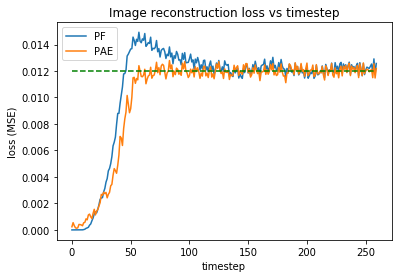

In [12]:
conf = copy.deepcopy(DEFAULT_SIM_CONFIG)
conf['radius'] = 2.0
conf['dynamics_noise'] = 0.01
conf['measurement_noise'] = 0.0003
conf['n_bodies'] = 1

w = World(**conf)
gif_counter = 3

pf = ParticleFilter(conf, n_particles=100)

pos = [body.pos for body in w.bodies]
vel = [body.vel for body in w.bodies]
pf.warm_start(pos, vel=vel)

ims = []

ims_percept = []
ims_pf_belief = []
ims_pf_sample = []

loss_mse = []
loss_sample_mse = []
loss_mae = []

RUN_LENGTH = 260

for i in range(RUN_LENGTH):
    if i < 8:
        measures = [body.pos for body in w.bodies]
        pf.update(measures)
        pf.resample()
    
    w.run()
    pf.predict()
    
    percept = w.draw()
    belief = pf.draw()[:,:,0]
    sample = pf.parts[np.random.randint(pf.n)].draw()
    
    loss_mse.append(np.mean((percept-belief)**2))
    loss_sample_mse.append(np.mean((percept-sample)**2))
    
    ims_percept.append(percept)
    ims_pf_belief.append(belief)
    ims_pf_sample.append(sample)

    
# run predictions with the network
x = np.array(ims_percept)
x = x.reshape((1, RUN_LENGTH, 28, 28, 1))
x[:,8:, ...] = 0
# x[:,:100, ...] = 0
# x[:,101:, ...] = 0

x = x.transpose((1, 0, 4, 2, 3))
x = torch.FloatTensor(x)
# x = x.cuda()
x = Variable(x)
states = pae.bs_prop(x)

# create expected observations
obs_expectation = pae.decoder(states)
obs_expectation = obs_expectation.view(x.size())

obs_expectation = obs_expectation.data.cpu().numpy()
obs_expectation = obs_expectation.reshape((RUN_LENGTH, 28, 28))


# create observation samples (constant or varying noise accross time)
noise = Variable(torch.FloatTensor(RUN_LENGTH, N_SIZE))
# noise = Variable(torch.FloatTensor(1, N_SIZE))
noise.data.normal_(0, 1)
# noise = noise.expand(RUN_LENGTH, N_SIZE)

# print('size', states.size())
#states_non_ep = states.unfold(0, 1, (EP_LEN*BATCH_SIZE)//GAN_BATCH_SIZE).squeeze(-1)

pae_samples = pae.G(noise, states.squeeze_(1))
pae_samples = pae.decoder(pae_samples)
pae_samples = pae_samples.view(x.size())
# print('size', pae_samples.size())

pae_samples = pae_samples.data.cpu().numpy()
pae_samples = pae_samples.reshape((RUN_LENGTH, 28, 28))

pae_ims = []
pae_samples_ims = []
loss_pae = []
for i in range(RUN_LENGTH):
    pae_ims.append(obs_expectation[i, ...])
    pae_samples_ims.append(pae_samples[i, ...])
    loss_pae.append(np.mean((ims_percept[i]-obs_expectation[i, ...])**2))

DURATION = 0.2
imageio.mimsave("ims/{}-percept.gif".format(gif_counter), ims_percept, duration=DURATION)
imageio.mimsave("ims/{}-pf_belief.gif".format(gif_counter), ims_pf_belief, duration=DURATION)
imageio.mimsave("ims/{}-pf_sample.gif".format(gif_counter), ims_pf_sample, duration=DURATION)
imageio.mimsave("ims/{}-pae_belief.gif".format(gif_counter), pae_ims, duration=DURATION)
imageio.mimsave("ims/{}-pae_sample.gif".format(gif_counter), pae_samples_ims, duration=DURATION)

ims_ar = np.array(ims_percept)
av_pixel_intensity = np.mean(ims_ar)
baseline_level = np.mean((ims_ar-av_pixel_intensity)**2)
baseline = np.ones(len(loss_mse)) * baseline_level
print("Uninformative baseline level at {}".format(baseline_level))

plt.plot(loss_mse)
plt.plot(loss_pae)
plt.plot(baseline, 'g--')

plt.title("Image reconstruction loss vs timestep")
plt.ylabel("loss (MSE)")
plt.xlabel("timestep")
plt.legend(["PF", "PAE"])

HTML("""
<table>
  <tr>
    <th>Ground truth</th>
    <th>Particle Filter</th> 
    <th>PF Sample</th> 
    <th>Predictive AE</th>
    <th>PAE Sample</th>
  </tr>
  <tr>
    <td><img src="../ims/{0}-percept.gif" width="140"></td>
    <td><img src="../ims/{0}-pf_belief.gif" width="140"></td> 
    <td><img src="../ims/{0}-pf_sample.gif" width="140"></td>
    <td><img src="../ims/{0}-pae_belief.gif" width="140"></td>
    <td><img src="../ims/{0}-pae_sample.gif" width="140"></td>
    
  </tr>

</table>""".format(gif_counter))